<a href="https://colab.research.google.com/github/flediak/tensor_flow_image_classification/blob/main/cifar10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# intro
This notebook classifies images of the CIFAR-10 dataset using 5 different neural networks. The networks are build with Tensor Flow and fitted using GPU acceleration. Finally the model performances are compared and tested for overfitting. These tests show that using convolutions of the input images
(i.e. Convolutional Neural Networks) improves the performance, but also leads to strong overfitting. The overfitting can be reduced by introducing dropout layers in the network.

In [1]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 668.3 MB 18 kB/s 
     |████████████████████████████████| 462 kB 24.4 MB/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed

In [2]:
from keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
print(tf.__version__)

2.8.0


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# read data

In [5]:
from keras.datasets import cifar10

In [6]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [7]:
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [8]:
X_train, X_test = X_train / 255., X_test / 255.

In [9]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [10]:
### for binary classification

'''
class1_name="cat"
class2_name="airplane"

# get IDs of class 1 and 2
class1_ID = np.arange(len(class_names))[np.array(class_names)==class1_name][0]
class2_ID = np.arange(len(class_names))[np.array(class_names)==class2_name][0]

# select the two classes from input data
select_train = (Y_train == class1_ID) | (Y_train == class2_ID)
select_test = (Y_test == class1_ID) | (Y_test == class2_ID)

X_train = X_train[select_train[:,0]]
Y_train = Y_train[select_train[:,0]]

X_test = X_test[select_test[:,0]]
Y_test = Y_test[select_test[:,0]]

# reset class values to 0 and 1 for class 1 and 2
Y_train = np.where(Y_train==class1_ID,0,1)
Y_test = np.where(Y_test==class1_ID,0,1)
'''

'\nclass1_name="cat"\nclass2_name="airplane"\n\n# get IDs of class 1 and 2\nclass1_ID = np.arange(len(class_names))[np.array(class_names)==class1_name][0]\nclass2_ID = np.arange(len(class_names))[np.array(class_names)==class2_name][0]\n\n# select the two classes from input data\nselect_train = (Y_train == class1_ID) | (Y_train == class2_ID)\nselect_test = (Y_test == class1_ID) | (Y_test == class2_ID)\n\nX_train = X_train[select_train[:,0]]\nY_train = Y_train[select_train[:,0]]\n\nX_test = X_test[select_test[:,0]]\nY_test = Y_test[select_test[:,0]]\n\n# reset class values to 0 and 1 for class 1 and 2\nY_train = np.where(Y_train==class1_ID,0,1)\nY_test = np.where(Y_test==class1_ID,0,1)\n'

# define models

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.95): # Experiment with changing this value
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

In [12]:
callbacks = myCallback()

see
https://www.tensorflow.org/guide/distributed_training

In [13]:
mirrored_strategy = tf.distribute.MirroredStrategy()

In [14]:
with mirrored_strategy.scope():

  modelA = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
  
  modelB = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation=tf.nn.relu),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  modelC = tf.keras.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  modelD = tf.keras.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

  modelE = tf.keras.Sequential([
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(32, 32, 3)),
      tf.keras.layers.MaxPooling2D((2,2)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation=tf.nn.relu),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

In [15]:
models = [modelA, modelB, modelC, modelD, modelE]

model_names = ['model A', ' model B', 'model C', 'model D', 'model E']

In [16]:
for model in models:
  model.compile( optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

# fit models

In [17]:
for i,model in enumerate(models):

  print('\nfit ' + model_names[i])
  model.fit(X_train, Y_train, validation_data=(X_test,Y_test), epochs=20, callbacks = myCallback())


fit model A
Epoch 1/20
1563/1563 [==============================] - 14s 6ms/step - loss: 1.8996 - accuracy: 0.3226 - val_loss: 1.7497 - val_accuracy: 0.3816
Epoch 2/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.7164 - accuracy: 0.3870 - val_loss: 1.6644 - val_accuracy: 0.4004
Epoch 3/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6540 - accuracy: 0.4103 - val_loss: 1.6067 - val_accuracy: 0.4245
Epoch 4/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6164 - accuracy: 0.4255 - val_loss: 1.6235 - val_accuracy: 0.4253
Epoch 5/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5884 - accuracy: 0.4374 - val_loss: 1.5754 - val_accuracy: 0.4370
Epoch 6/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5668 - accuracy: 0.4442 - val_loss: 1.5921 - val_accuracy: 0.4313
Epoch 7/20
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5478 - accuracy: 0.4517 - val_loss: 1.6026 -

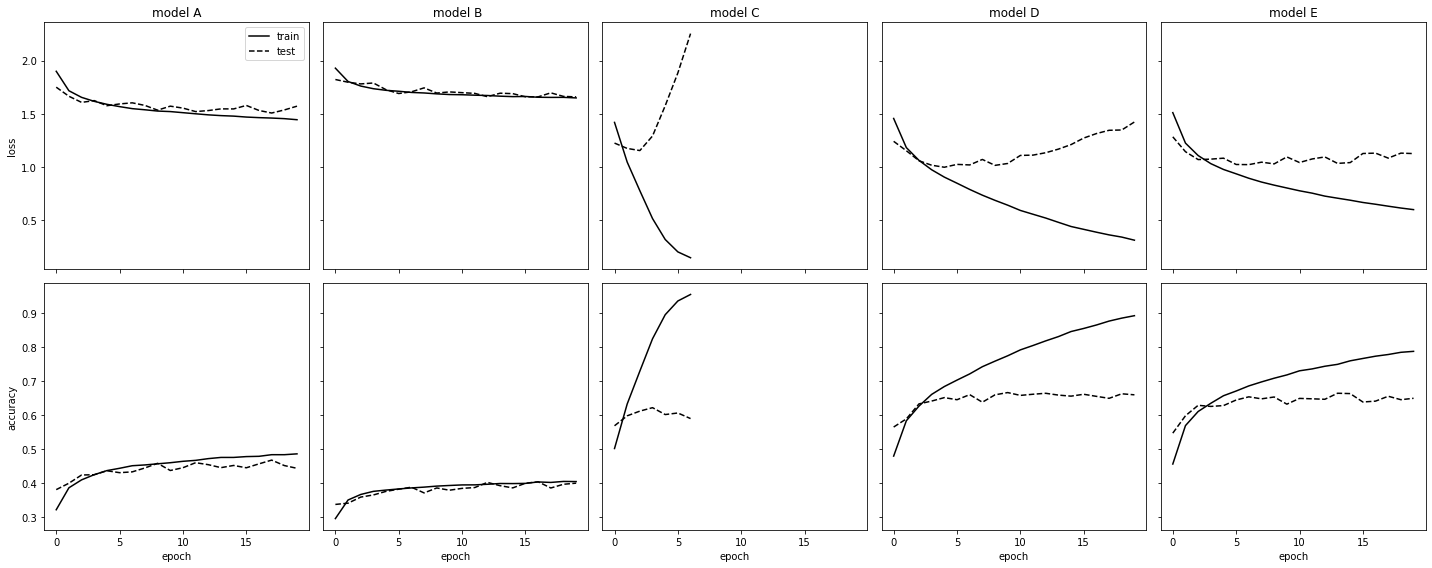

In [18]:
fig, ax = plt.subplots(2,len(models), figsize=(20,8), sharex=True, sharey='row')

ax[0,0].set_ylabel('loss')
ax[1,0].set_ylabel('accuracy')

for i in range(len(models)):
  ax[-1,i].set_xlabel('epoch')
  ax[0,i].set_title(model_names[i])

for i,model in enumerate(models):
  ax[0,i].plot(model.history.history['loss'], c='k', label = 'train')
  ax[0,i].plot(model.history.history['val_loss'], c='k', ls='--', label='test')
  ax[1,i].plot(model.history.history['accuracy'], c='k')
  ax[1,i].plot(model.history.history['val_accuracy'], c='k', ls='--')

ax[0,0].legend()

plt.tight_layout()
plt.show()

In [22]:
for i,model in enumerate(models):
  print('\nevaluate ' + model_names[i])
  model.evaluate(X_test, Y_test)


evaluate model A
313/313 [==============================] - 1s 4ms/step - loss: 1.5711 - accuracy: 0.4441

evaluate  model B
313/313 [==============================] - 1s 4ms/step - loss: 1.6585 - accuracy: 0.4006

evaluate model C
313/313 [==============================] - 2s 5ms/step - loss: 2.2545 - accuracy: 0.5900

evaluate model D
313/313 [==============================] - 1s 4ms/step - loss: 1.4221 - accuracy: 0.6597

evaluate model E
313/313 [==============================] - 1s 4ms/step - loss: 1.1244 - accuracy: 0.6495


# plot model predictions

In [20]:
classifications = modelE.predict(X_test)
Y_model = np.argmax(classifications, axis=1)

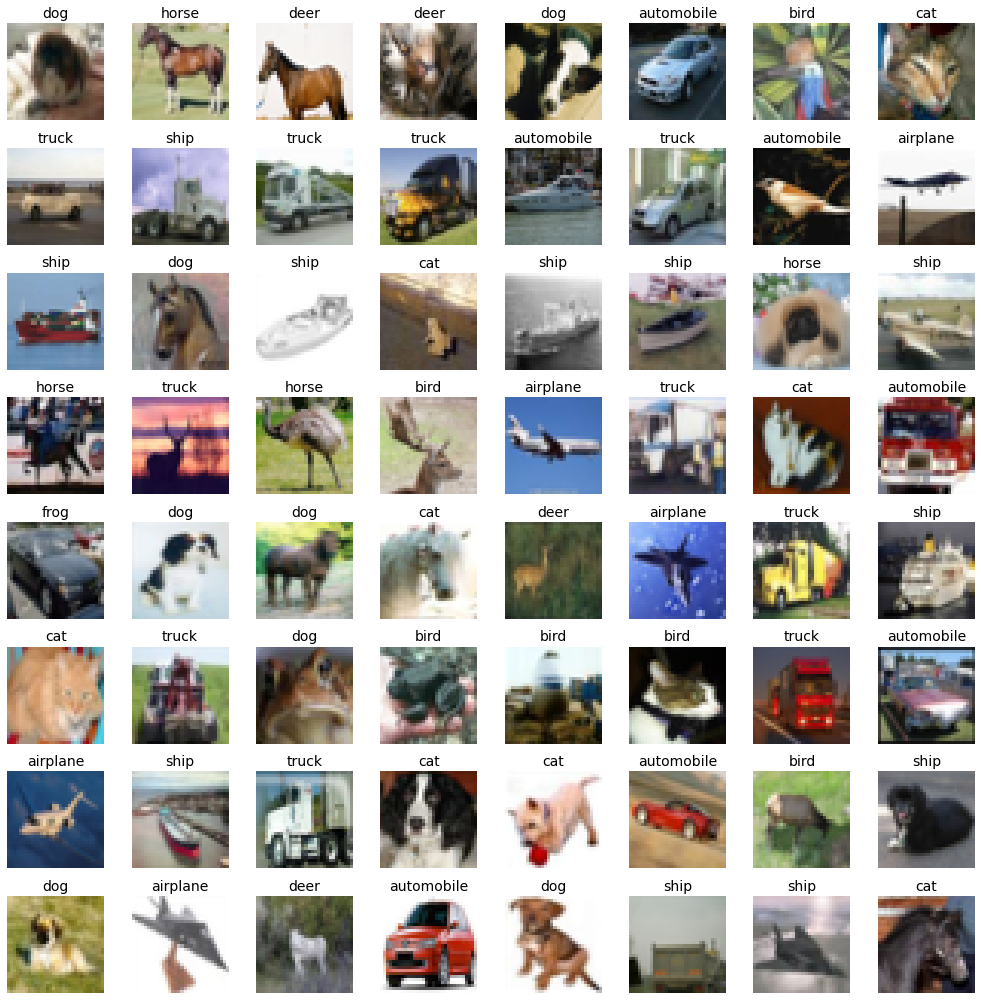

In [21]:
fig, ax = plt.subplots(8,8, figsize=(14,14))

imgID = 200
for ix in range(8):
    for iy in range(8):
        
        #if Y_model[imgID]==0:
        #    title = class1_name
        #else:
        #    title = class2_name
        title = class_names[Y_model[imgID]]

        ax[iy, ix].set_title(title, fontsize=14)
        
        ax[iy, ix].imshow(X_test[imgID], cmap=plt.get_cmap('gray'))
        
        ax[iy, ix].axis('off')
        
        imgID+=1
                

plt.tight_layout()            
plt.show()